In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marcellopoliti","key":"0f1ed88a8dbe45fd8a20f10299e39954"}'}

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download "datamunge/sign-language-mnist"

 89% 56.0M/62.6M [00:00<00:00, 40.7MB/s]
100% 62.6M/62.6M [00:00<00:00, 75.9MB/s]


##Extract Files

In [4]:
import zipfile

zip_ref = zipfile.ZipFile("/content/sign-language-mnist.zip","r")
zip_ref.extractall("./data")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
training = pd.read_csv("/content/data/sign_mnist_train/sign_mnist_train.csv")
testing = pd.read_csv("/content/data/sign_mnist_test/sign_mnist_test.csv")

##Split Train Val

In [156]:
#shuffle
training = training.sample(frac=1)

train_size = 0.80
train = training[0:int(len(training)*train_size)]
val = training[int(len(training)*train_size):]

x_train , y_train = train.drop(["label"],axis = 1) , train.label
x_val, y_val = val.drop(["label"],axis = 1) , val.label

x_train.shape,y_train.shape, x_val.shape, y_val.shape

((21964, 784), (21964,), (5491, 784), (5491,))

In [204]:
from sklearn.model_selection import train_test_split

x , y = training.drop(["label"],axis = 1) , training.label

x_train, x_val, y_train, y_val = train_test_split (x,y , train_size = 0.8 ,stratify = y)

##Plot one sample

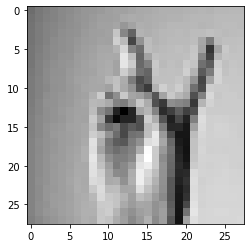

In [110]:
plt.imshow(x_train.iloc[0,:].values.reshape(28,28), cmap = "gray")

In [205]:
#reshape
x_train = x_train.values.reshape(-1,28,28,1)
x_val = x_val.values.reshape(-1,28,28,1)
#y_train = tf.one_hot(y_train.values.reshape(-1),24)
#y_val = tf.one_hot(y_val.values.reshape(-1),24)

##Data Augmentation

In [206]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [207]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32,
    shuffle = True
  )

val_generator = train_datagen.flow(
    x_val,
    y_val,
    batch_size=32,
    shuffle = True
  )

In [208]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential

In [209]:
model = Sequential([
  Conv2D(filters =32, kernel_size = (3,3), activation = "relu",input_shape=(28,28,1)),
  MaxPooling2D((2,2)),
  Conv2D(filters =64, kernel_size = (3,3), activation = "relu",),
  MaxPooling2D((2,2)),
  Conv2D(filters =64, kernel_size = (3,3), activation = "relu",),
  #MaxPooling2D((2,2)),

  Flatten(),
  Dense(128, activation = "relu"),
  Dropout(0.3),
  Dense(25,activation = "softmax")
])

In [210]:
model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])

##Define callbacks

In [211]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 4,  
    restore_best_weights=True
)

In [212]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(x_train)/32,
    validation_steps = len(x_val)/32,
    epochs = 40,
    validation_data = val_generator,
    callbacks = [early_stopping]
)

Epoch 1/40
686/686 [==============================] - 11s 15ms/step - loss: 2.9506 - accuracy: 0.1012 - val_loss: 2.5490 - val_accuracy: 0.1898
Epoch 2/40
686/686 [==============================] - 10s 15ms/step - loss: 2.3599 - accuracy: 0.2372 - val_loss: 1.9441 - val_accuracy: 0.3637
Epoch 3/40
686/686 [==============================] - 10s 15ms/step - loss: 1.8977 - accuracy: 0.3728 - val_loss: 1.5719 - val_accuracy: 0.4863
Epoch 4/40
686/686 [==============================] - 10s 15ms/step - loss: 1.5898 - accuracy: 0.4629 - val_loss: 1.3603 - val_accuracy: 0.5451
Epoch 5/40
686/686 [==============================] - 10s 15ms/step - loss: 1.3844 - accuracy: 0.5292 - val_loss: 1.1564 - val_accuracy: 0.6119
Epoch 6/40
686/686 [==============================] - 10s 15ms/step - loss: 1.2424 - accuracy: 0.5734 - val_loss: 1.0407 - val_accuracy: 0.6567
Epoch 7/40
686/686 [==============================] - 12s 18ms/step - loss: 1.1464 - accuracy: 0.6086 - val_loss: 0.9097 - val_accuracy:

##Test the model

In [213]:
testing = pd.read_csv("/content/data/sign_mnist_test/sign_mnist_test.csv")
testing.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [214]:
x_test = testing.drop(["label"],axis = 1)
y_test = testing.label

In [215]:
#reshape
x_test = x_test.values.reshape(-1,28,28,1)
y_test = y_test.values.reshape(-1)

In [216]:
model.evaluate(x_test/255.0 , y_test)

225/225 [==============================] - 1s 3ms/step - loss: 0.1407 - accuracy: 0.9437


[0.1407497078180313, 0.943669855594635]